## Vision Transformer

Is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.

As you can see in the figure, a Transformer is nothing more than a sequence of layers formed by:

*   The multi-head attention mechanism
*   Normalization and residual connection (inspired by ResNet)
*   A MLP
*   Other normalization and residual connection

Also, at the input of the first layer, we have an embedding stage to project our inputs to the appropriate dimension to which we add a postitional encoding, the mechanism that will tell the transformer where each vector is in the sequence.

## Dataset

In [ ]:
!pip install pytorch-lightning

In [ ]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X 
        self.y = y 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        return torch.tensor(self.X[ix]).float().view(1, 28, 28), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [ ]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

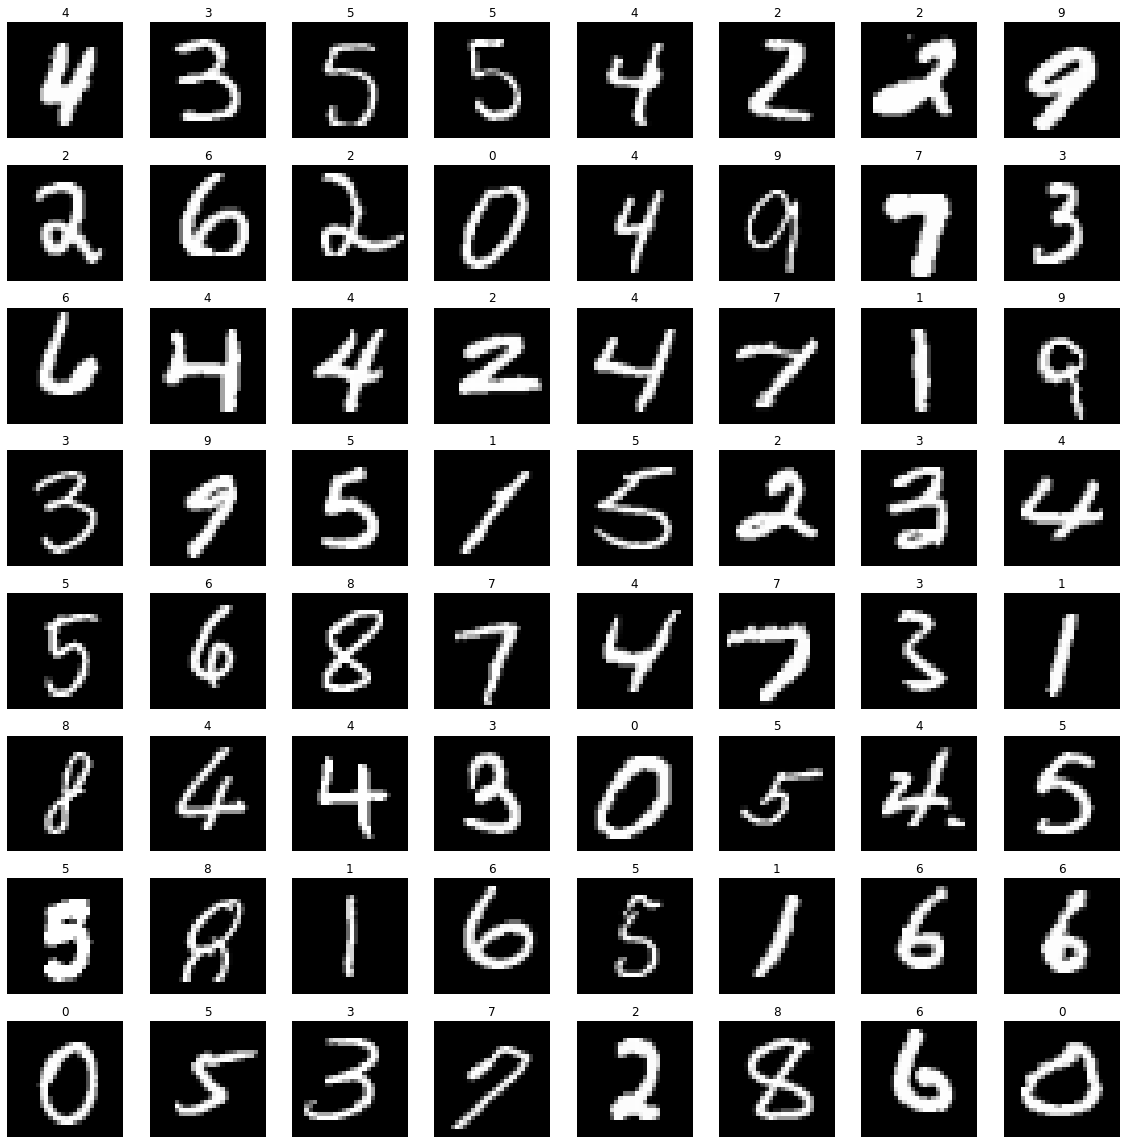

In [ ]:
r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

## Model

Implementation of the patch embedding, this module will receive a batch of images and will be in charge of projecting the different patches.

For this we can use a convolutional layer with a kernel and stride size equal to the size of the patch we want to use.

In [ ]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [ ]:
pe = PatchEmbedding(28, 7, 1, 100)
out = pe(imgs)
out.shape

torch.Size([64, 16, 100])

Once we have the projected data, we can give it to the transformer encoder.

In [ ]:
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd*n_heads)
        self.query = nn.Linear(n_embd, n_embd*n_heads)
        self.value = nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

It would be necessary to add the token class and the postitional embeddings. In Vision Transformer, a special token is used at the beginning of the sequence, to which we connect our final classifier.

In [ ]:
class ViT(nn.Module):

    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=100, n_heads=3, n_layers=3, n_classes=10):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)])
        
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        e = self.patch_embed(x)
        B, L, E = e.size()
        
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        e = torch.cat((cls_token, e), dim=1)  # (B, 1 + N, E)
        e = e + self.pos_embed  # (B, 1 + N, E)
        
        z = self.tranformer(e)
        
        cls_token_final = z[:, 0]  
        y = self.fc(cls_token_final)

        return y

In [ ]:
vit = ViT()
out = vit(imgs)
out.shape

torch.Size([64, 10])

In [ ]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.vit = ViT()

    def forward(self, x):
        return self.vit(x)

    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [ ]:
model = Model()
out = model(imgs)
out.shape

torch.Size([64, 10])

In [ ]:
model = Model()
trainer = pl.Trainer(max_epochs=5, gpus=1, logger=None)
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


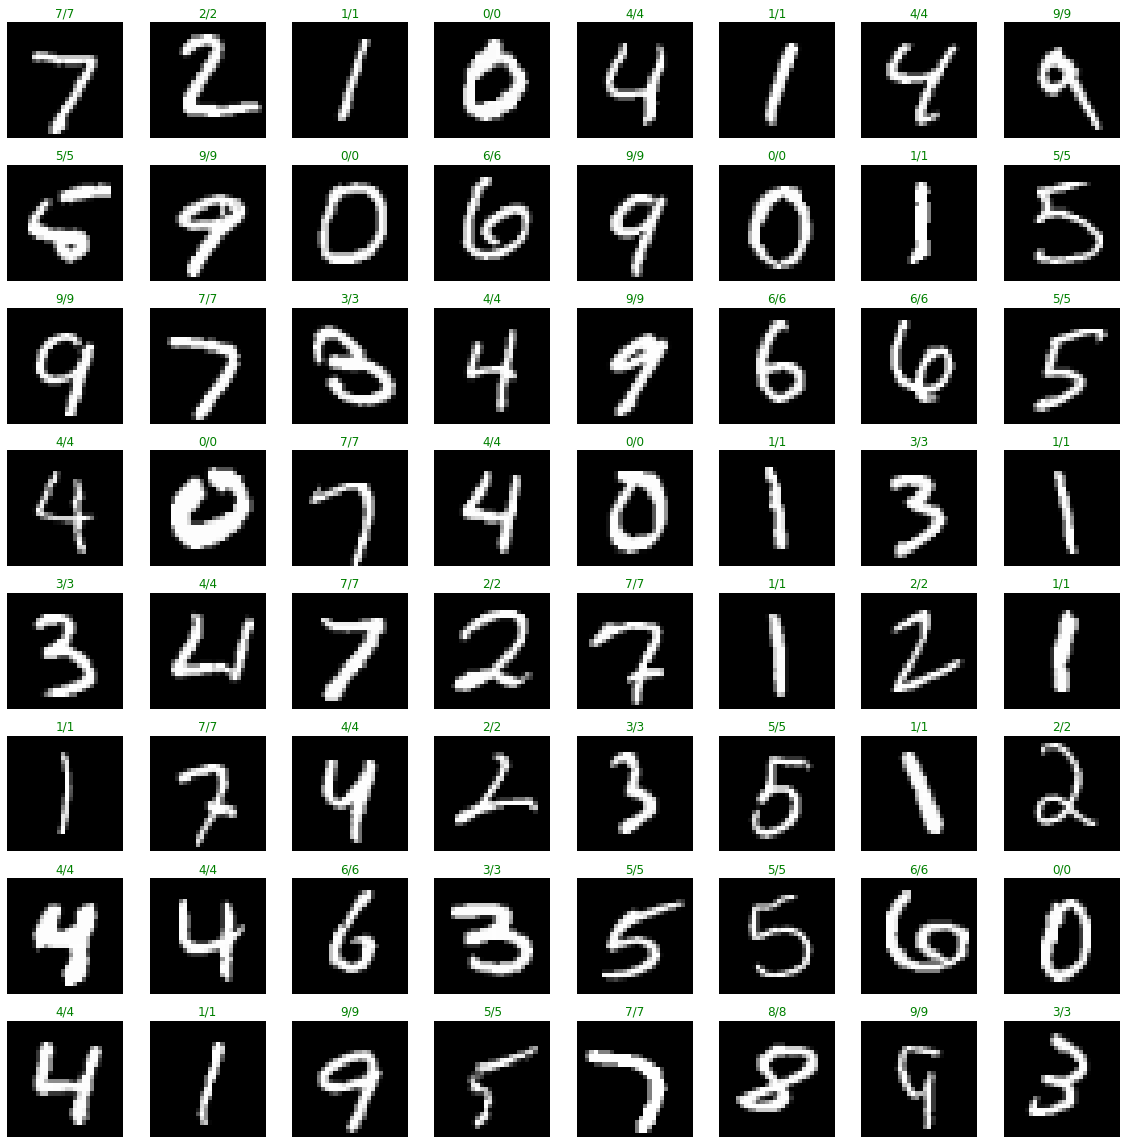

In [ ]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Although our implementation is functional, we can use other ones that already exist to make sure that everything is well implemented and optimized.

In [ ]:
# !pip install timm

In [ ]:
from timm.models.vision_transformer import VisionTransformer

# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

class Model2(Model):
    def __init__(self):
        super().__init__()
        self.vit = VisionTransformer(
            img_size=28, 
            patch_size=7, 
            in_chans=1, 
            num_classes=10, 
            embed_dim=100, 
            depth=3, 
            num_heads=2
        )

In [ ]:
model2 = Model2()
out = model2(imgs)
out.shape

torch.Size([64, 10])

In [ ]:
model2 = Model2()
trainer = pl.Trainer(max_epochs=5, gpus=1, precision=16, logger=None)
trainer.fit(model2, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and i

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


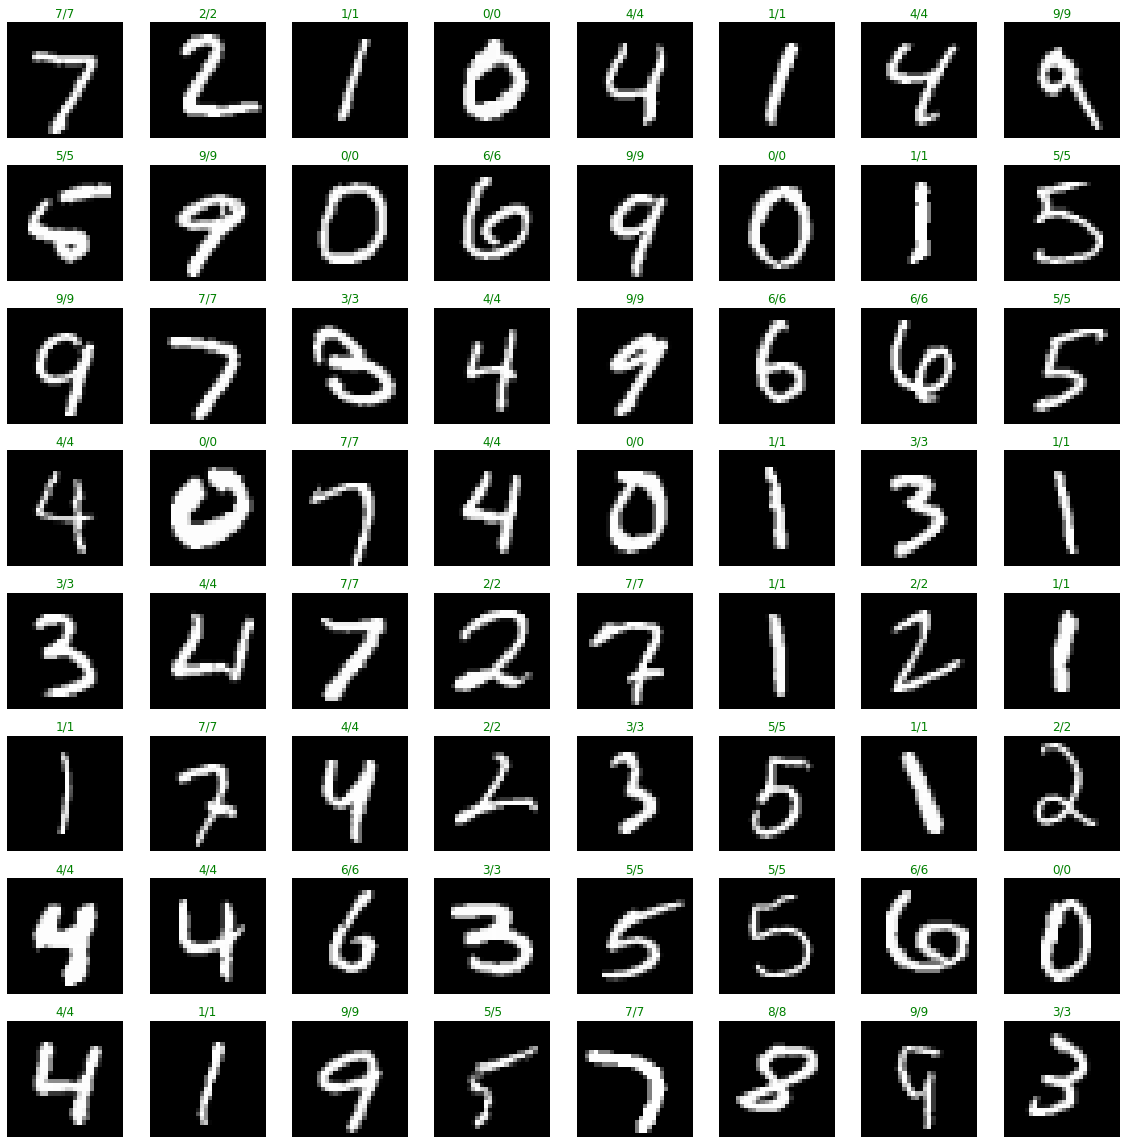

In [ ]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

In this case the difference in the number of parameters and precision is due to the fact that in the original implementation of the Transformer, the calculation of the keys, queries and values is divided between the different heads, while in our implementation (due to the low dimensionality of the problem) we are multiplying them.